## Table of contents:
* [Identify the most important attributes in predicting the price of a property](#identify-properties)
* [Valuate the price of  a property using predictive models](#property-valuation)

### Import libraries

In [72]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [73]:
!pip install plotly
!pip install -U kaleido
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import plotly.express as px
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Requirement already up-to-date: kaleido in /Users/vm/opt/anaconda3/envs/vm/lib/python3.8/site-packages (0.2.1)


In [74]:
# Added a switch between showing interactive plotly graphs and .png (plotly plots don't show in github)
plotly="no"

In [75]:
data = pd.read_csv('assignment_rev2.csv')

In [76]:
def clean_dataset(data):
    data = data[(data['sq_meters'] != 1) & (data['sq_meters'] != 14000)]
    data = data[(data['year_of_construction'] != 1070) ]
    data = data[(data['rooms'] != 255) ]
    data = data[(data['price'] > 1000) ]
    # Drop where agent_id is null
    data = data.dropna(subset=['agent_id'])
    return data
                              
data=clean_dataset(data)
# Drop duplicate listings
props=['sq_meters','subtype','geography_name','floor','rooms','living_rooms', 'kitchens','no_of_wc',
                             'year_of_construction','no_of_bathrooms']
data=data.drop_duplicates(subset=props, keep='first')

### Identify the most important attributes in predicting the price of a property <a class="anchor" id="identify-attributes"></a>

There would be many different ways for identifying the most important features for predicting the price of a listing.
Assuming a linear relationship between the variables we can use a correlation coefficient (e.g. Pearsons) which tells us how much corellated our variables are. This works only for numerical variables. Moreover, nowdays a lot of algorithms can do feature selection while buidling the model and we can then extract the results.

What we would expect is that the bigger the house n terms of square meters, rooms, number of bathrooms, etc. the higher the price of it. Also, judging from our analysis previously the area of the listings has an important impact on its price.

#### Calculate correlation matrix

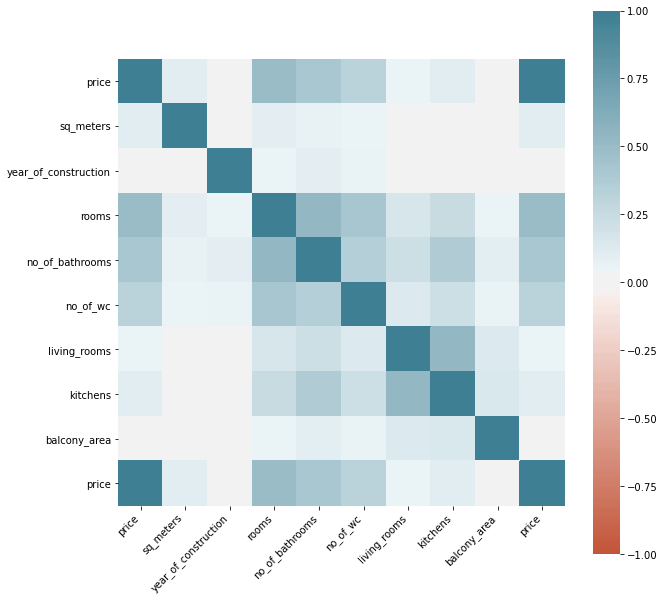

In [77]:
fig, ax = plt.subplots(figsize=(10,10)) 
cor_data=data[["price","sq_meters","year_of_construction","rooms",
                "no_of_bathrooms","no_of_wc","living_rooms","kitchens","balcony_area","price"]]
corr = cor_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

As we see from the correlation matrix above the rooms, the number of bathrooms and the number of WCs have the higher correlation with the price. The square meters of the listing seem to be less corellated

#### Feature importance using a random forest regressor

By using a random forest we can also incorporate categotical features to get their realtive importance.
I will exclude the features that have a lot of nan values though it might be sensible to try see how the algorithm performs when we impute the missing values.

In [78]:
# Drop nan
model_data=data[["ranking_score","geography_name","sq_meters","price","year_of_construction","floor","subtype","rooms",
                "no_of_bathrooms","no_of_wc","ad_type","living_rooms","kitchens","balcony_area"]]
model_data=model_data.dropna(axis='rows')
model_data.head(10)

,ranking_score,geography_name,sq_meters,price,year_of_construction,floor,subtype,rooms,no_of_bathrooms,no_of_wc,ad_type,living_rooms,kitchens,balcony_area
0,47.0,northern sub,567,200000,2005,1,apartment,4,0,0,simple,0,0,0
1,134.7,northern sub,642,550000,1992,ground-floor,detached,5,4,1,simple,1,1,0
2,71.0,northern sub,320,500000,2009,ground-floor,detached,2,2,1,simple,0,0,0
3,122.0,northern sub,95,230000,2007,1,apartment,3,1,1,simple,0,1,0
4,126.7,northern sub,195,370000,2007,ground-floor,maisonette,4,1,2,simple,0,1,0
5,133.8,northern sub,318,560000,2011,ground-floor,detached,6,5,1,simple,0,3,0
6,116.5,northern sub,291,970000,2010,ground-floor,maisonette,3,2,1,simple,1,1,0
8,154.5,northern sub,400,850000,2008,ground-floor,detached,6,4,1,simple,2,2,0
9,27.8,northern sub,583,220000,2155,ground-floor,detached,0,0,0,simple,0,0,0
10,160.5,northern sub,440,1050000,1994,ground-floor,detached,4,5,1,simple,2,1,0


In [79]:
categorical_features = ["geography_name", "subtype","floor"]
numerical_features = ["sq_meters","year_of_construction","rooms",
                     "no_of_bathrooms","no_of_wc","living_rooms","kitchens","balcony_area"]
# Our taget variable is the price
y= model_data["price"]
X = model_data[categorical_features + numerical_features]

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  random_state=42)

# Use one hot encodeing for the categorical features
cat_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', cat_encoder, categorical_features),
     ('num', numerical_pipe, numerical_features)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(random_state=42)) # Use random forest regressor
])
rf.fit(X_train, y_train)
print("Train score: %0.3f" % rf.score(X_train, y_train))
print("Test score: %0.3f" % rf.score(X_test, y_test))

Train score: 0.961
Test score: 0.609


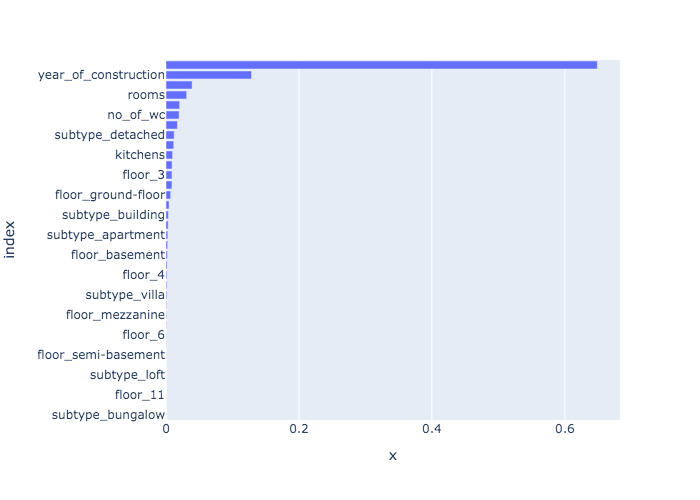

In [80]:
# Plot the feature importance
steps = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feat_names = steps.get_feature_names(input_features=categorical_features)
feat_names = np.r_[feat_names, numerical_features]
rf_feature_importance = (
    rf.named_steps['regressor'].feature_importances_)
sorted_idx = rf_feature_importance.argsort()
sorted_idx = rf_feature_importance.argsort()
feat_data = pd.DataFrame(data=[rf_feature_importance[sorted_idx]],  columns=feat_names[sorted_idx])
fig = px.bar(feat_data.T, y=feat_data.T.index, x=feat_data.T[0])
if plotly=='yes':
    fig.show()
else:
    fig.show("png")
# First entry below are the square meters (not sure why it suppresses the name)

As seen in the chart above the square meters and the year of construction are the two features that have the higher score. The area and the type of the apartment also seem to play an important role when it comes to predicting the price of a listing.

### Valuate the price of  a property using predictive models <a class="anchor" id="property-valuation"></a>

The dataset has a total of 15447 values for 55 features. We drop the rows that have less than 1000 nan values per feature or else we drop the features themselves. The number of nan values can be seen here. 

In [81]:
model_data.isnull().sum()
model_data=model_data.dropna(axis='columns')

#### Prepare train and test set

In [82]:
X = model_data.drop('price', 1)
y = model_data[['price']]
num_columns=["ranking_score","sq_meters","year_of_construction","rooms","no_of_bathrooms","living_rooms",
            "kitchens","balcony_area"]
X.head(5)

,ranking_score,geography_name,sq_meters,year_of_construction,floor,subtype,rooms,no_of_bathrooms,no_of_wc,ad_type,living_rooms,kitchens,balcony_area
0,47.0,northern sub,567,2005,1,apartment,4,0,0,simple,0,0,0
1,134.7,northern sub,642,1992,ground-floor,detached,5,4,1,simple,1,1,0
2,71.0,northern sub,320,2009,ground-floor,detached,2,2,1,simple,0,0,0
3,122.0,northern sub,95,2007,1,apartment,3,1,1,simple,0,1,0
4,126.7,northern sub,195,2007,ground-floor,maisonette,4,1,2,simple,0,1,0


Since we want to include both numerical and categorical variables in our models we should first scale the numerical features and encode the categorical ones using. For this I used the scikit standard scaler and one hot encoding.

In [83]:
# Scale the numerical features
scaler = StandardScaler()
# Fit scaler to training data only
X[num_columns] = scaler.fit_transform(X[num_columns])
y = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
# Get categorical features
categorical = X.select_dtypes(include='O').keys()
# display features
categorical
# Encode categorical features
dummies = pd.get_dummies(X[categorical])
X_old_=X.drop(['geography_name', 'floor', 'subtype', 'ad_type'], axis = 1)
X=pd.concat([X_old_, dummies], axis=1)
X.head(5)

,ranking_score,sq_meters,year_of_construction,rooms,no_of_bathrooms,no_of_wc,living_rooms,kitchens,balcony_area,geography_name_beesy neighborhood,...,subtype_detached,subtype_loft,subtype_maisonette,subtype_other residential,subtype_studio,subtype_villa,ad_type_premium,ad_type_simple,ad_type_star,ad_type_up
0,-2.192355,0.284297,0.178859,0.591515,-1.263522,0,-0.518590,-0.840498,-0.225068,0,...,0,0,0,0,0,0,0,1,0,0
1,0.569298,0.344383,0.136769,1.162102,1.701146,1,0.403867,0.555187,-0.225068,0,...,1,0,0,0,0,0,0,1,0,0
2,-1.436601,0.086413,0.191809,-0.549658,0.218812,1,-0.518590,-0.840498,-0.225068,0,...,1,0,0,0,0,0,0,1,0,0
3,0.169378,-0.093846,0.185334,0.020929,-0.522355,1,-0.518590,0.555187,-0.225068,0,...,0,0,0,0,0,0,0,1,0,0
4,0.317380,-0.013731,0.185334,0.591515,-0.522355,2,-0.518590,0.555187,-0.225068,0,...,0,0,1,0,0,0,0,1,0,0


In [84]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

As a first model we can use a simple linear regresion model

#### Linear model

In [85]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_test)
print("The mean absolute score for the linear model is ", round(mean_absolute_error(y_test, y_pred),2))

The mean absolute score for the linear model is  335550.82


In [86]:
# Function for ploting predictions

def plot_predictions(y_pred,y_test):
    output = pd.concat([pd.DataFrame(y_pred[0:500],columns=["predictions"]), pd.DataFrame(y_test[0:500],columns=["actuals"])], axis=1)
    output['MAE']=abs(output['actuals']-output['predictions'])
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter( x=output.index, y=output['predictions'],name="predictions"))
    fig.add_trace(go.Scatter( x=output.index, y=output['actuals'],name="actuals"))
    fig.update_layout(
        autosize=False,
        width=900,
        height=600,)
    fig.update_layout(

        title="Actual prices vs predictions",
    )
    fig.update_yaxes(title_text="Apartment price in Euros", secondary_y=False)
    fig.update_xaxes(title="Apartment index")
    if plotly=='yes':
        fig.show()
    else:
        fig.show("png")

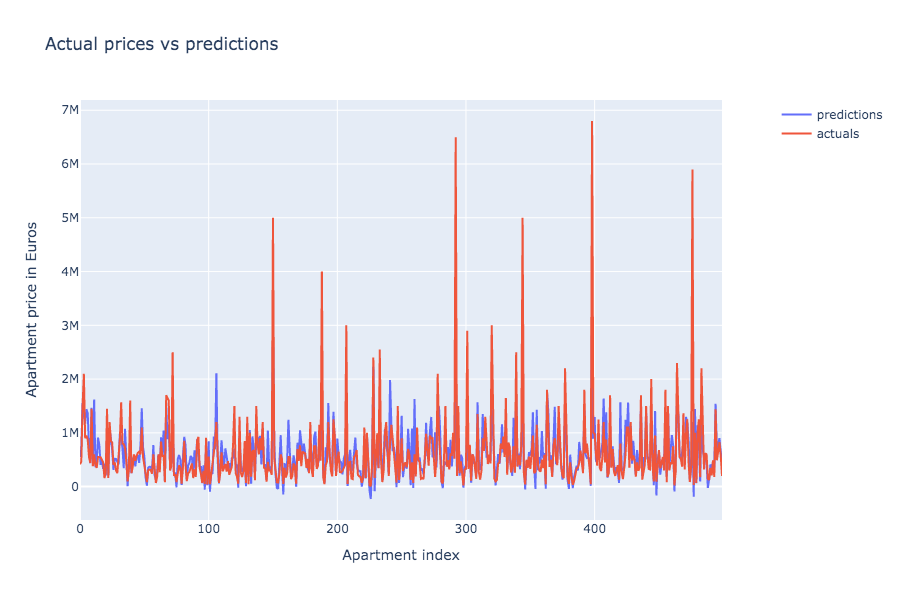

In [87]:
#Plot output linear model for 200 listings
plot_predictions(y_pred,y_test)

We see that the model performs better for lower value listings while accuracy falls in higher value ones.

#### Train a xgboost regressor
One of the most effective models for handling both categorical and numerical valuesis XGBoost. We can try this and check its prefromance

In [88]:
# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Inverse predictions
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_test)
print(model)
print("The mean absolute score for the linear model is ", round(mean_absolute_error(y_test, y_pred),2))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
The mean absolute score for the linear model is  172953.76


Mean absolut error is improved compared to the linear model

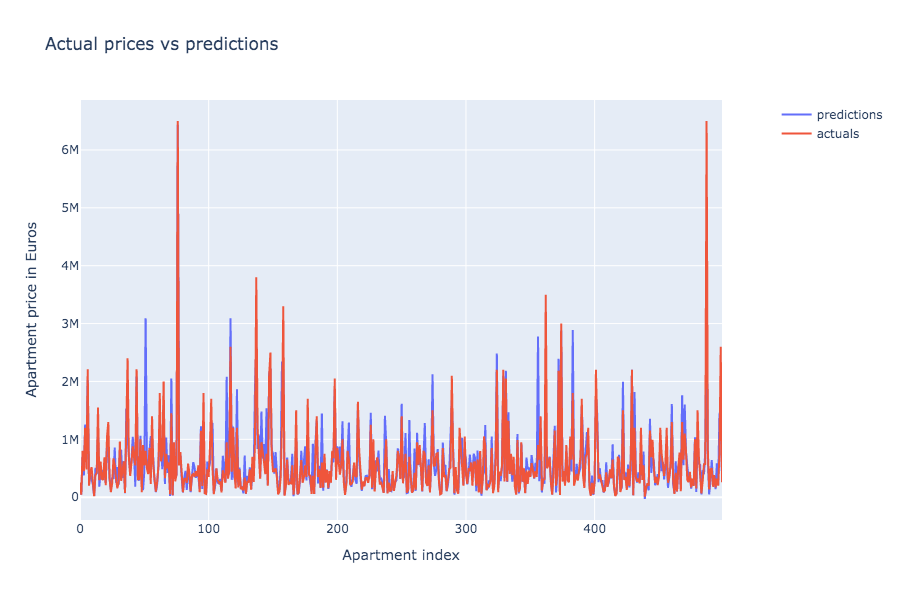

In [89]:
# Plot predictions for the first 500 listings of the test set
plot_predictions(y_pred,y_test)

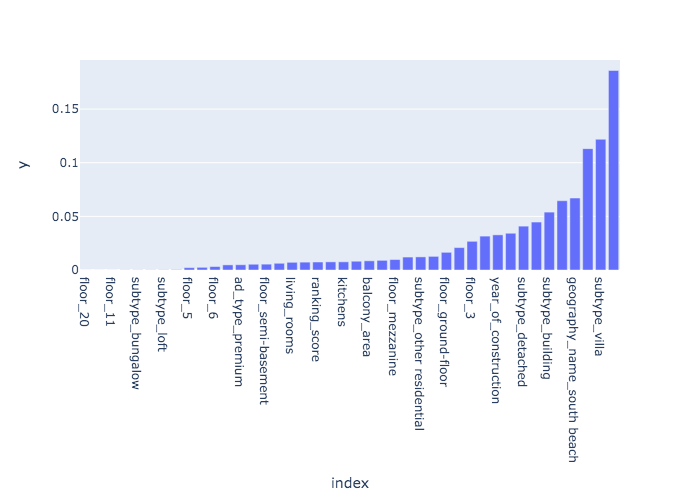

In [90]:
# As we did with the random forest we can also get feature importance from the xgboost regressor
model.feature_importances_
sorted_idx = model.feature_importances_.argsort()
df = pd.DataFrame(data=[model.feature_importances_[sorted_idx]],  columns=X_train.columns[sorted_idx].values)
fig = px.bar(df.T, x=df.T.index, y=df.T[0])
if plotly=='yes':
    fig.show()
else:
    fig.show("png")

Feature importance is more or less the same as the one from random forest. Square meters rank higher, with area and apartment types following.

#### Tuning hyperparameters of xgboost

There are many ways to tune the hyperpameters of the the regressor. One of them is to use grid search. Hyperopt is another more efficinet way to do it.

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

param_grid = dict(
     gamma= [1],# 0,2
     learning_rate= [0.5], #0.01,0.3
     n_estimators=[1100],
     max_depth=[6]) # 5,6,10,20

model = XGBRegressor(random_state=1, verbosity=1) 

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                          )
# Could take a while to fit
best_model = grid_search.fit(X_train, y_train)
print('Best model parameters', best_model.best_params_)

Best model parameters {'gamma': 1, 'learning_rate': 0.5, 'max_depth': 6, 'n_estimators': 1100}


In [92]:
# Predict with best model and inverse predictions
y_pred = best_model.predict(X_test)
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_test)
print("The mean absolute score is ", round(mean_absolute_error(y_test, y_pred),2))

The mean absolute score is  188642.34


Mean absolute error improved slightly improved compared to previous model

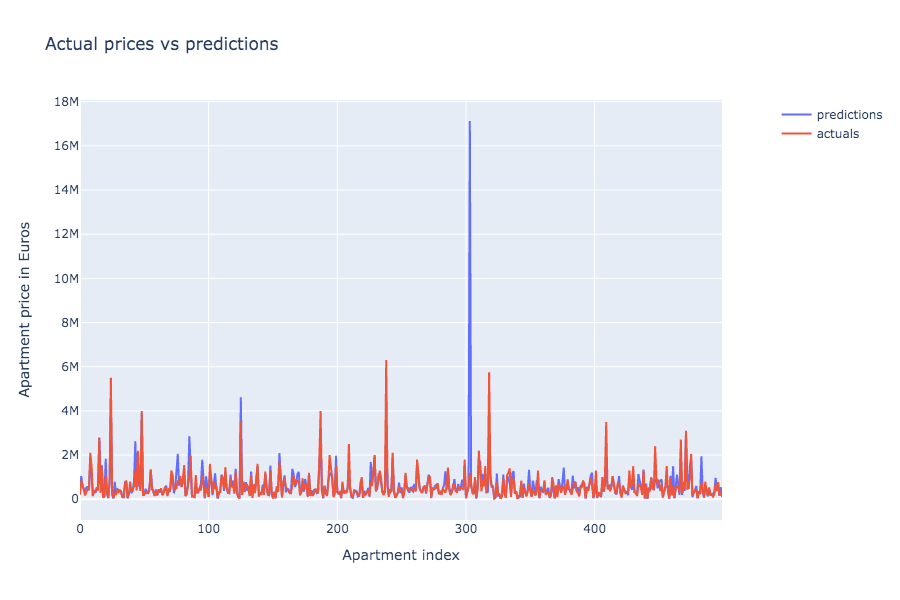

In [93]:
# Plot predictions for the first 500 listings of the test set
plot_predictions(y_pred,y_test)

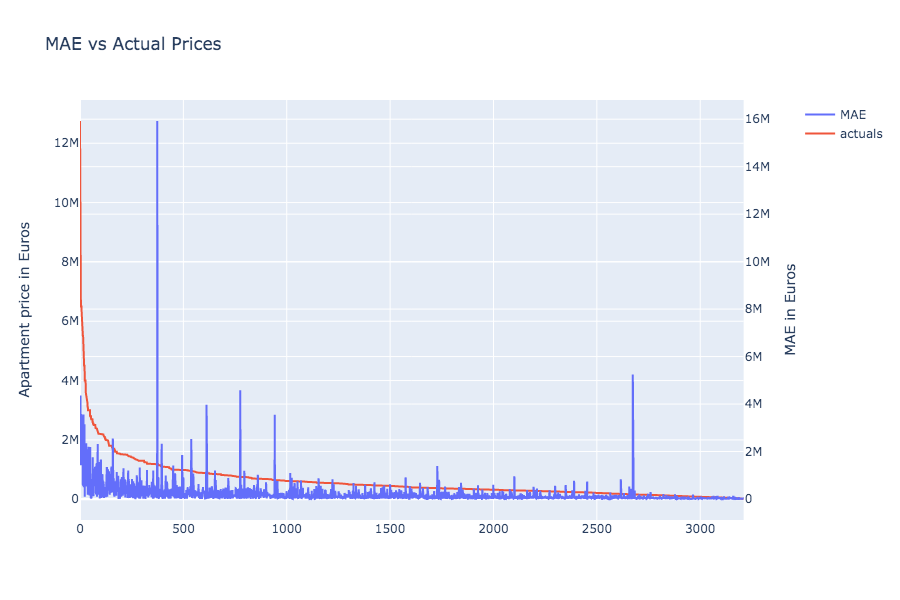

In [94]:
def plot_MAE(y_pred,y_test):
    output = pd.concat([pd.DataFrame(y_pred,columns=["predictions"]), pd.DataFrame(y_test,columns=["actuals"])], axis=1)
    output['MAE']=abs(output['actuals']-output['predictions'])
    ordered=output.sort_values([('actuals')], ascending=False)
    ordered=ordered.reset_index(drop=True)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter( x=ordered.index, y=ordered['MAE'],name="MAE"), secondary_y=True)
    fig.add_trace(go.Scatter( x=ordered.index, y=ordered['actuals'],name="actuals"), secondary_y=False)
    fig.update_layout(
        autosize=False,
        width=900,
        height=600,)
    fig.update_layout(

        title="MAE vs Actual Prices",
    )
    fig.update_yaxes(title_text="Apartment price in Euros", secondary_y=False)
    fig.update_yaxes(title_text="MAE in Euros", secondary_y=True)
    fig.update_xaxes(title="")
    if plotly=='yes':
        fig.show()
    else:
        fig.show("png")

plot_MAE(y_pred,y_test)


### Things that could potentialy improve forecasting performance
 - Adding more data is always the first thing that comes to mind
 - Imputing the missing values for the rest of the features and using thme in the model as well could potenitally impreove performance
 - Trying other models like ridge, lasso regression
 - Trying different sets of inputs or simpler models with less features
    

### Trying our stuff 

Since we have excluded a lot of features from our previous models maybe it would make sense to impute the missing values of the features we didn't use. There is always the question of how much missing values per feature are too much so as to drop the feature. In our case we will exclude features that have over 10k of missing values.

In [95]:
# Read data and drop duplicates
data = pd.read_csv('assignment_rev2.csv')
data=clean_dataset(data) # Function from above
# Remove duplicates
props=['sq_meters','subtype','geography_name','floor','rooms','living_rooms', 'kitchens','no_of_wc',
                             'year_of_construction','no_of_bathrooms']
data=data.drop_duplicates(subset=props, keep='first')

In [96]:
# Remove irrelevant features or too many nans in a a column
data_new=data.drop(['id','ranking_score','agent_id', 'energy_class','renovation_year','equipped',
                    'accessible_for_disabled'], axis = 1)


In [97]:
! pip install verstack

In [98]:
from verstack import NaNImputer
imputer= NaNImputer(verbose = True)
data_new_imputed = imputer.impute(data_new)


Dataset dimensions:
 - rows:         13558
 - columns:      49
 - mb in memory: 5.17
 - NaN cols num: 37
--------------------------
Changed (fixed) column lux_home to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column new_development to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column garage to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column furnished to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column preserved to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column investment to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column unfinished to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column heating_under_floor to type float
Incorrectly represented values replaced by np.nan

Changed (fixed) column renovated to type float
Incorrectly represente

In [99]:
X = data_new_imputed.drop('price', 1)
y = data_new_imputed[['price']]

In [100]:
# Scale the numerical features
scaler = StandardScaler()
# Fit scaler to training data only
num_columns = X._get_numeric_data().columns
num_columns
X[num_columns] = scaler.fit_transform(X[num_columns])
y = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
# Get categorical features
categorical = X.select_dtypes(include='O').keys()
# display features
categorical
# Encode categorical features
dummies = pd.get_dummies(X[categorical])
X_old_=X.drop(['geography_name', 'floor', 'subtype', 'ad_type'], axis = 1)
X=pd.concat([X_old_, dummies], axis=1)
X.head(5)

,sq_meters,year_of_construction,rooms,no_of_bathrooms,no_of_wc,living_rooms,kitchens,balcony_area,lux_home,new_development,...,subtype_detached,subtype_loft,subtype_maisonette,subtype_other residential,subtype_studio,subtype_villa,ad_type_premium,ad_type_simple,ad_type_star,ad_type_up
0,0.285605,0.184604,0.558373,-1.268188,-0.806227,-0.521611,-0.840986,-0.221304,0.952590,-0.714709,...,0,0,0,0,0,0,0,1,0,0
1,0.347230,0.144241,1.115185,1.637814,0.398404,0.407082,0.526663,-0.221304,-1.049769,-0.714709,...,1,0,0,0,0,0,0,1,0,0
2,0.082652,0.197024,-0.555251,0.184813,0.398404,-0.521611,-0.840986,-0.221304,0.952590,1.399171,...,1,0,0,0,0,0,0,1,0,0
3,-0.102224,0.190814,0.001561,-0.541687,0.398404,-0.521611,0.526663,-0.221304,-1.049769,-0.714709,...,0,0,0,0,0,0,0,1,0,0
4,-0.020057,0.190814,0.558373,-0.541687,1.603036,-0.521611,0.526663,-0.221304,-1.049769,-0.714709,...,0,0,1,0,0,0,0,1,0,0


In [101]:
# Train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Inverse predictions
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_test)
print(model)
print("The mean absolute score for the model is ", round(mean_absolute_error(y_test, y_pred),2))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
The mean absolute score for the model is  172144.87


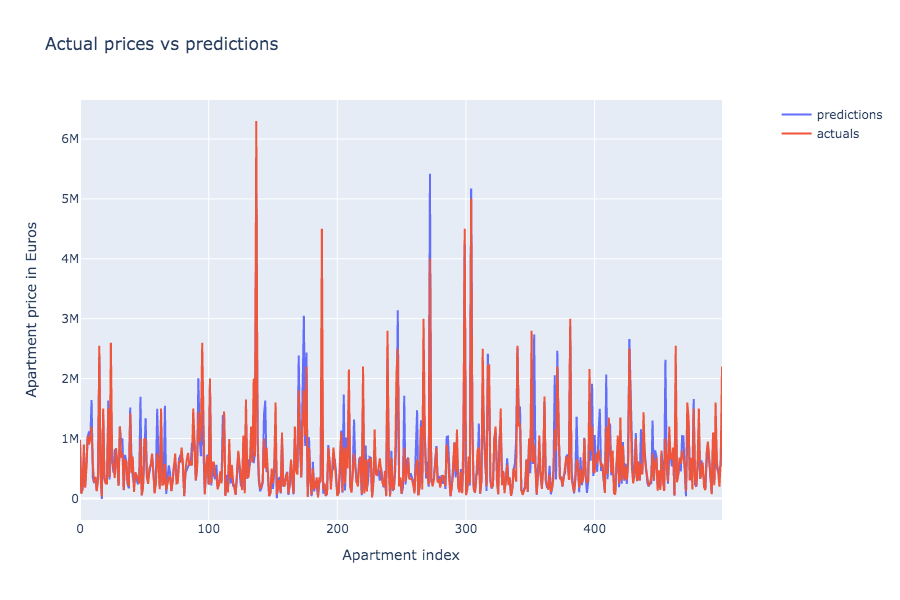

In [102]:
plot_predictions(y_pred,y_test)